First part of the code is similar to Geoff's code; for the stationary equilibrium part, I learn from quantecon and write a version of myself.

In [672]:
import numpy as np
import matplotlib.pyplot as plt #pictures
from numba import njit
from numba import prange

In [673]:
#impoert quantecon
import quantecon as qe

In [674]:
#set up parameters and transitional matrix
tol=1e-10
R = 1.0505
w = 0.0560
beta = 0.95
grid_number = 3
sigma = 2

#transitional matrix
l = np.array([0.1, 1.0, 1.25])
 
#l = np.array([0.1, 1.0, 1.25])
trans_matrix = np.mat('0.5 0.4 0.1; 0.2 0.7 0.1; 0.2 0.2 0.6')
#trans_matrix = np.mat('0.6 0.4 0.0; 0.1 0.85 0.05; 0.0 0.1 0.9')
print(trans_matrix)

[[0.5 0.4 0.1]
 [0.2 0.7 0.1]
 [0.2 0.2 0.6]]


In [675]:
def stationary_labor_generator(P):
    mc = qe.MarkovChain(P)
    return mc.stationary_distributions

In [676]:
labor_station = stationary_labor_generator(trans_matrix)
def solve_mu(labor_station,l_1,l_2):
    z = np.linspace(1,2,100)
    expectation_origin = np.sum(labor_station*l)
    new_expectation = np.zeros(100)
    for i in range(100):
        new_expectation[i] = np.sum(np.array([l_1,l_2,z[i]])*labor_station)
    expectation_diff = new_expectation - expectation_origin
    max_expectation = np.minimum(expectation_diff , 0)
    return z[int(np.argmax(max_expectation))]

In [677]:
#Calculate mu
mu = solve_mu(labor_station,0.07,1.0)
print(mu)
#l = np.array([0.07,1,mu])

1.2929292929292928


In [678]:
#The problem
#V(a,l) = max_c u(c) + beta*E[V(a', l')| l]
#c+a'=Ra+wl and a'>=a_under

#@njit
#def u(c):
    #c_prime = np.maximum(0,c)
    #return np.log(c)#np.log(c_prime)
#the log function should ensure that c>0. What if we do not include the condition of c>0 here?

# Partial equilibrium

In [679]:
@njit
def u(c):
    arg = np.maximum(0,c)
    return np.log(arg)

In [680]:
#set up grid
a_lower = -0.1 
a_lower_1 = 0
#a_lower = 0
a_upper = 3 #from course material, we know CRRA(sigma=1) implies an upper bound of saving; let's first try 20 as an upper bound
N_a = 200
a_grid = np.linspace(a_lower, a_upper, N_a)

In [681]:
@njit
def Bellman_operator(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w):#(l, a_grid, grid_number, N_a, trans_matrix, V_guess_0, R, w, beta):
    V_save=np.zeros_like(V_guess)
    policy_save=np.zeros_like(V_guess)
    V_compare=np.zeros(N_a)

    for il in range(grid_number):

        conditional_l=trans_matrix[il]
        EV_future=np.zeros(N_a)
        #expected future value
        for ilt in prange(grid_number):
            EV_future+=V_guess[ilt]*conditional_l[ilt] #V_guess[iyp] is an array, while conditional_y[iyp] is a number. Therefore, EV_future is also an array

        for ia in prange(N_a): #this is today's asset holding

            for iat in range(N_a): #tomorrow's asset holding, want to make a choice and maximize utility
                #how to add borrowing constraint?
                c=R*a_grid[ia]+w*l[il]-a_grid[iat]
                
                V_compare[iat]=u(c)+beta*EV_future[iat] #choose different a'
            if np.max(V_compare) == -1*np.inf:
                policy = a_grid[ia]
                policy_save[il,ia]=policy
                V_save[il,ia]= -100
            else:
                policy=np.argmax(V_compare) #choose a' such that V is the max
                policy_save[il,ia]=policy
                c=R*a_grid[ia]+w*l[il]-a_grid[policy]
                V_save[il,ia]=u(c)+beta*EV_future[policy]

    return V_save,policy_save

In [682]:
#trial to see if there is any error in the function
V_guess = np.zeros((grid_number, N_a))
trial_V,trial_policy = Bellman_operator(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)

In [683]:
#def value_func_iteration(V_guess_0,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w):#(l, a_grid, grid_number, N_a, trans_matrix, V_guess_0, R, w, beta):
#    error = 2
#    itr = 1
#    v_guess = V_guess_0
#    while error>tol and itr<=100:
#        itr+=1
#        V_update= Bellman_operator(v_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)[0]
#        error=np.max(np.abs(v_guess-V_update))
#        v_guess=V_update
#    print(itr)
#    print(error)
#    return Bellman_operator(v_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)

In [684]:
def value_func_iteration(V_guess_0,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w):
    V_guess=V_guess_0
    error=1
    itr=1
    while error>tol and itr<=100:
        itr+=1
        V_update=Bellman_operator(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)[0]
        error=np.max(np.abs(V_guess-V_update))#sup norm
        V_guess=V_update
    return Bellman_operator(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)

In [685]:
V_guess = np.zeros((grid_number, N_a))
V,policy = value_func_iteration(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)

#  Value function is as follows. From the lightest color to the darkest color corresponds to labor endowment from low to high

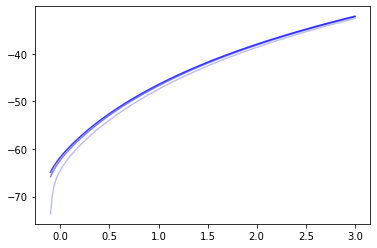

In [686]:
#value function value(too close to distinguish)
for i in range(grid_number):
    plt.plot(a_grid,V[i],color='b',alpha=(i+1)/(grid_number+1))

# Policy function... Unfortunately, three policy function conditional on labor endowment coincide (I mean on the graph).

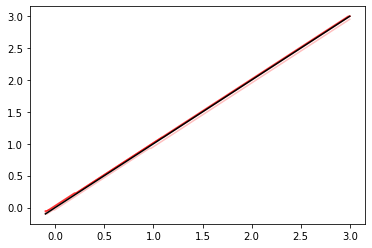

In [687]:
#policy function value
a_policy = np.zeros((grid_number,N_a))
for i in range(grid_number):
    for j in range(N_a):
        m = policy[i,j]
        a_policy[i,j] = a_grid[int(m)]
for i in range(grid_number):
    plt.plot(a_grid,a_policy[i],color='r',alpha=(i+1)/(grid_number+1))
plt.plot(a_grid,a_grid,color='k')

In [688]:
#different borrowing limit
def borrow_limit(a_lower,grid_number,N_a,l,trans_matrix,beta,R,w):
    a_grid_1 = np.linspace(a_lower, a_upper, N_a)
    V_guess = np.zeros((grid_number, N_a))
    V,policy = value_func_iteration(V_guess,a_grid_1,N_a,l,grid_number,trans_matrix,beta,R,w)
    a_policy = np.zeros((grid_number,N_a))
    for i in range(grid_number):
        for j in range(N_a):
            m = policy[i,j]
            a_policy[i,j] = a_grid_1[int(m)]
    for i in range(grid_number):
        plt.plot(a_grid_1,a_policy[i],color='r',alpha=(i+1)/(grid_number+1))
    plt.plot(a_grid_1,a_grid_1,color='k')

# Different borrow limit

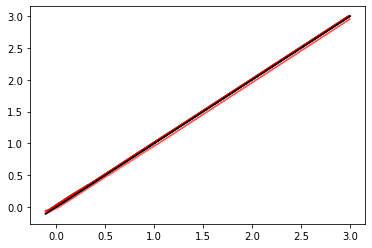

In [689]:
borrow_lower = np.array([-0.11,-0.1,-0.05,0.0])
for i in range(len(borrow_lower)):
    borrow_limit(borrow_lower[i],grid_number,N_a,l,trans_matrix,beta,R,w)

In [690]:
#different borrowing limit
def interest_rate(a_grid,grid_number,N_a,l,trans_matrix,beta,R,w):
    V_guess = np.zeros((grid_number, N_a))
    V,policy = value_func_iteration(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R,w)
    a_policy = np.zeros((grid_number,N_a))
    for i in range(grid_number):
        for j in range(N_a):
            m = policy[i,j]
            a_policy[i,j] = a_grid[int(m)]
    for i in range(grid_number):
        plt.plot(a_grid,a_policy[i],color='r',alpha=(i+1)/(grid_number+1))
    plt.plot(a_grid,a_grid,color='k')

# Different interest rate

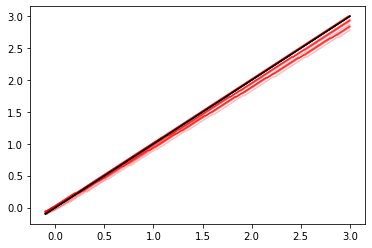

In [691]:
r_1 = np.array([0.01,0.03,0.0505])
R_1 = 1 + r_1
for i in range(len(R_1)):
    interest_rate(a_grid,grid_number,N_a,l,trans_matrix,beta,R_1[i],w)

# General equilibrium(stationary)

In [692]:
!pip install quantecon

In [693]:
#Stationary distribution
#At stationary equilibrium, there is a invariant joint distribution of labor endowment and wealth; we then first derive this.
#Since we want to use quantecon package to derive our stationary distribution, we deal with the indices as follows:
#We make s_i = a_i * grid_number + l_i
#In this way, we change a matrix distribution into a vector; 
#Besides, we could restore a_i as s_i//grid_number, restore z_i as s_i%grid_number 
#This vector is of length (grid_number*N_a)

#Now we define the function to generate the transitional matrix ((grid_number*N_a)*(grid_number*N_a))) for this vector

n = grid_number*N_a
@njit
def stationary_trans_matrix_generator(policy,n_state,trans_matrix):
    matrix_save = np.zeros((n_state,n_state))
    for a_i in range(N_a):
        for l_i in range(grid_number):
            a_new = int(policy[l_i,a_i])
            for l_j in range(grid_number):
                matrix_save[a_i*grid_number+l_i, a_new*grid_number + l_j] = trans_matrix[l_i,l_j]
    return matrix_save

In [694]:
#Stationary distribution
#At stationary equilibrium, there is a invariant joint distribution of labor endowment and wealth; we then first derive this.
#Since we want to use quantecon package to derive our stationary distribution, we deal with the indices as follows:
#We make s_i = a_i * grid_number + l_i
#In this way, we change a matrix distribution into a vector; 
#Besides, we could restore a_i as s_i//grid_number, restore z_i as s_i%grid_number 
#This vector is of length (grid_number*N_a)

#Now we define the function to generate the transitional matrix ((grid_number*N_a)*(grid_number*N_a))) for this vector

n = grid_number*N_a
@njit
def stationary_trans_matrix_generator(policy,n_state,trans_matrix):
    matrix_save = np.zeros((n_state,n_state))
    for a_i in range(N_a):
        for l_i in range(grid_number):
            a_new = int(policy[l_i,a_i])
            for l_j in range(grid_number):
                matrix_save[a_i*grid_number+l_i, a_new*grid_number + l_j] = trans_matrix[l_i,l_j]
    return matrix_save

In [695]:
#Now we find a function to generate the stationary distribution by using quantecon
def stationary_distribution_generator(P):
    mc = qe.MarkovChain(P)
    return mc.stationary_distributions

In [696]:
#Set up function to calculate marginal distribution of stationary distribution of capital.
@njit
def marginal_capital_distribution(stationary_vector):
    prob_a = np.zeros(N_a)
    for a_i in range(N_a):
        for l_i in range(grid_number):
            prob_a[a_i] += stationary_vector[a_i*grid_number+l_i]
    return prob_a

In [697]:
@njit
def marginal_labor_distribution(stationary_vector):
    prob_l = np.zeros(grid_number)
    for l_i in range(grid_number):
        for a_i in range(N_a):
            prob_l[l_i] += stationary_vector[a_i*grid_number+l_i]
    return prob_l

In [698]:
#Compute the stationary distribution of labor endowment
#Since no matter what, the labor endowment of the economy is in one single transtional matrix, we then could directly calculate its stationary 
#distribution
def stationary_labor_distribution(trans_matrix,l,grid_number):
    stationary_labor_dist = stationary_distribution_generator(trans_matrix)
    stationary_labor_dist_1 = stationary_labor_dist[0]
    L = 0 
    for i in range(grid_number):
        L += stationary_labor_dist_1[i]*l[i]
    return stationary_labor_dist_1,L

In [699]:
#set up functions that solves for firm's setting of interest rate and wage given capital

#set ip parameters


z = 0.1
alpha = 0.3
delta = 0
N = 1#labor_stationary_distribution[1]

#set up functions
def r_capital(K,N):
    return z*alpha*(N/K)**(1-alpha) - delta

def w_to_r(r):
    return z*(1-alpha)*(z*alpha/(r+delta))**(alpha/(1-alpha))

In [700]:
#Define a function to generate the stationary total labor supply when interest rate is r
def prices_to_capital_stock(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,r):
    n = grid_number*N_a
    w_g = w_to_r(r)
    R_g = 1 + r
    V_g,policy_g = value_func_iteration(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R_g,w_g)
    state_trans_matrix = stationary_trans_matrix_generator(policy_g,n,trans_matrix)
    stationary_distribution = stationary_distribution_generator(state_trans_matrix)[0]
    asset_probs = marginal_capital_distribution(stationary_distribution)
    return np.sum(asset_probs*a_grid)

In [701]:
#Trial on this function 
V_guess_0 = np.zeros((grid_number, N_a))
r = 0.0505
print(prices_to_capital_stock(V_guess_0,a_grid,N_a,l,grid_number,trans_matrix,beta,r))
r_1 = 0.1
print(prices_to_capital_stock(V_guess_0,a_grid,N_a,l,grid_number,trans_matrix,beta,r_1))

0.8719114864671107
3.0


0.015249864400005544


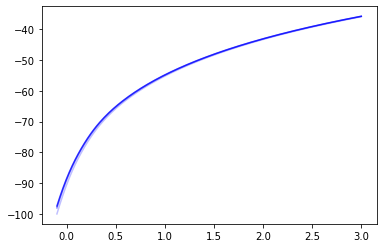

In [702]:
R_g = 1 + 0.0505
w_g = w_to_r(R_g)
print(w_g)
V_g,policy_g = value_func_iteration(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R_g,w_g)
for i in range(grid_number):
    plt.plot(a_grid,V_g[i],color='b',alpha=(i+1)/(grid_number+1))

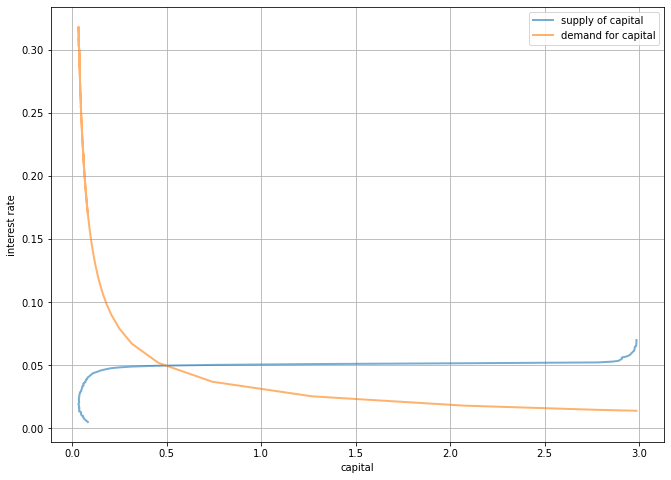

In [703]:
#Now we begin to draw the Ayagari model of capital supply and capital demand
# Create a grid of r values at which to compute demand and supply of capital
num_points = 100
r_vals = np.linspace(0.005, 0.07,num_points)

#First supply of capital
k_vals = np.empty(num_points)
for i,r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(V_guess_0,a_grid,N_a,l,grid_number,trans_matrix,beta,r)
    
#plot this two
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, r_capital(k_vals,N), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.show()

In [704]:
#Now we define function calculate the interest rate
def solve_interest_rate(r_compare,r_vals):
    r_length = np.size(r_compare)
    r_save = 0
    for i in range(r_length):
        if r_compare[i] >=0:
            r_save += 1
        else:
            break
    return r_vals[r_save-1]

# Q1: interest rate and corresponding wage rate

In [705]:
#Solve for interest rate and wage rate truly
r_compare = r_capital(k_vals,N) - r_vals
r_ge = solve_interest_rate(r_compare,r_vals)
w_ge = w_to_r(solve_interest_rate(r_compare,r_vals))
print(solve_interest_rate(r_compare,r_vals))
print(w_to_r(solve_interest_rate(r_compare,r_vals)))

0.04964646464646465
0.05640800278071117


In [706]:
#Now we plot the invariant distribution of wealth depending on labor endowment
n = grid_number*N_a
R_ge = 1 + r_ge
V_ge,policy_ge = value_func_iteration(V_guess,a_grid,N_a,l,grid_number,trans_matrix,beta,R_ge,w_ge)
state_trans_matrix_ge = stationary_trans_matrix_generator(policy_ge,n,trans_matrix)
stationary_distribution_ge = stationary_distribution_generator(state_trans_matrix_ge)[0]
#Extract the stationary distribution as a matrix of shape 3 * 200
stationary_distribution_matrix_ge = np.zeros((3,200))
for i in range(grid_number):
    for j in range(N_a):
        stationary_distribution_matrix_ge[i,j] = stationary_distribution_ge[j*grid_number+i]
stationary_conditional_distribution_matrix_ge = np.zeros((3,200))
for i in range(grid_number):
    for j in range(N_a):
        stationary_conditional_distribution_matrix_ge[i,j] = stationary_distribution_matrix_ge[i,j]/np.sum(stationary_distribution_matrix_ge[i])

# Q1: Invariant wealth distribution conditional on labor endowment

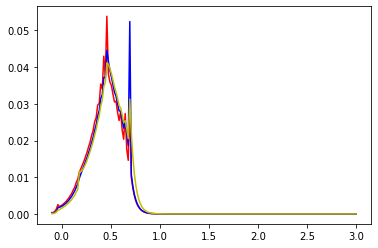

In [707]:
plt.plot(a_grid,stationary_conditional_distribution_matrix_ge[0],color='r',)
plt.plot(a_grid,stationary_conditional_distribution_matrix_ge[1],color='b')
plt.plot(a_grid,stationary_conditional_distribution_matrix_ge[2],color='y')

In [708]:
#This is a test function to see if the sum of probability is 1.
print(np.sum(stationary_distribution_matrix_ge[1])+np.sum(stationary_distribution_matrix_ge[2])+np.sum(stationary_distribution_matrix_ge[0]))
print(np.sum(stationary_conditional_distribution_matrix_ge[1]))

1.0000000000000004
1.0


In [709]:
def optimal_consumption_choice(policy,w,r,l,grid_number, N_a):
    save_optimal_consumption = np.zeros((grid_number,N_a))
    for l_i in range(grid_number):
        for a_i in range(N_a):
            save_optimal_consumption[l_i,a_i] = w*l[l_i] + (1+r)*a_grid[a_i] - a_grid[int(policy[l_i,a_i])]
    return save_optimal_consumption

In [710]:
optimal_consumption = optimal_consumption_choice(policy_ge, w_to_r(solve_interest_rate(r_compare,r_vals)),solve_interest_rate(r_compare,r_vals),l,grid_number, N_a)

# Q1: Optimal consumption policy

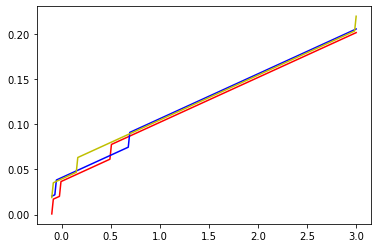

In [711]:
plt.plot(a_grid,optimal_consumption[0],color='r',)
plt.plot(a_grid,optimal_consumption[1],color='b')
plt.plot(a_grid,optimal_consumption[2],color='y')

In [712]:
def problem_solver(a_lower,trans_matrix,l):
    a_grid_1 = np.linspace(a_lower,a_upper,N_a)
    k_vals_1 = np.empty(num_points)
    for i,r in enumerate(r_vals):
        k_vals_1[i] = prices_to_capital_stock(V_guess_0,a_grid_1,N_a,l,grid_number,trans_matrix,beta,r)
    
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.plot(k_vals_1, r_vals, lw=2, alpha=0.6, label='supply of capital')
    ax.plot(k_vals_1, r_capital(k_vals_1,N), lw=2, alpha=0.6, label='demand for capital')
    ax.grid()
    ax.set_xlabel('capital')
    ax.set_ylabel('interest rate')
    ax.legend(loc='upper right')
    plt.show()
    
    r_compare_1 = r_capital(k_vals_1,N) - r_vals
    r_ge_1 = solve_interest_rate(r_compare_1,r_vals)
    w_ge_1 = w_to_r(solve_interest_rate(r_compare_1,r_vals))
    
    #Plot the invariant distribution
    n = grid_number*N_a
    R_ge_1 = 1 + r_ge_1
    V_ge_1,policy_ge_1 = value_func_iteration(V_guess,a_grid_1,N_a,l,grid_number,trans_matrix,beta,R_ge_1,w_ge_1)
    state_trans_matrix_ge_1 = stationary_trans_matrix_generator(policy_ge_1,n,trans_matrix)
    stationary_distribution_ge_1 = stationary_distribution_generator(state_trans_matrix_ge_1)[0]
    #Extract the stationary distribution as a matrix of shape 3 * 200
    stationary_distribution_matrix_ge_1 = np.zeros((3,200))
    for i in range(grid_number):
        for j in range(N_a):
            stationary_distribution_matrix_ge_1[i,j] = stationary_distribution_ge_1[j*grid_number+i]
    stationary_conditional_distribution_matrix_ge_1 = np.zeros((3,200))
    for i in range(grid_number):
        for j in range(N_a):
            stationary_conditional_distribution_matrix_ge_1[i,j] = stationary_distribution_matrix_ge_1[i,j]/np.sum(stationary_distribution_matrix_ge_1[i])
    plt.subplot(1,2,1)
    plt.plot(a_grid_1,stationary_conditional_distribution_matrix_ge_1[0],color='r',)
    plt.plot(a_grid,stationary_conditional_distribution_matrix_ge_1[1],color='b')
    plt.plot(a_grid,stationary_conditional_distribution_matrix_ge_1[2],color='y')
    
    #Plot consumption 
    plt.subplot(1,2,2)
    optimal_consumption_1 = optimal_consumption_choice(policy_ge_1, w_to_r(solve_interest_rate(r_compare_1,r_vals)),solve_interest_rate(r_compare_1,r_vals),l,grid_number, N_a)
    plt.plot(a_grid_1,optimal_consumption_1[0],color='r',)
    plt.plot(a_grid_1,optimal_consumption_1[1],color='b')
    plt.plot(a_grid_1,optimal_consumption_1[2],color='y')
    
    #Compute wage rate and interest rate
    print(solve_interest_rate(r_compare_1,r_vals))
    print(w_to_r(solve_interest_rate(r_compare_1,r_vals)))

# Q2: Lower bound of asset is 0

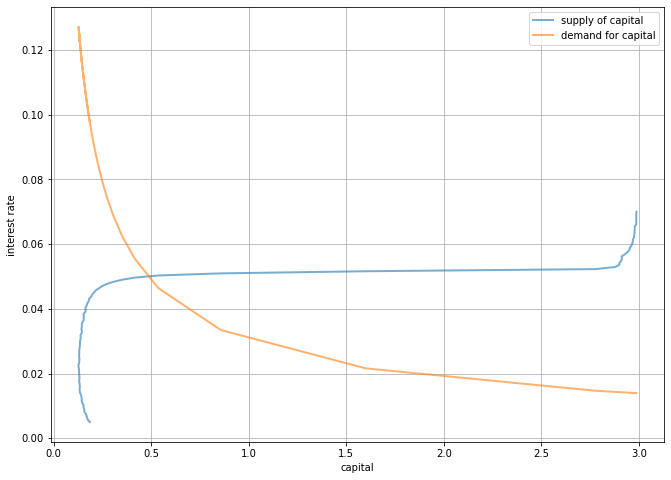

0.04964646464646465
0.05640800278071117


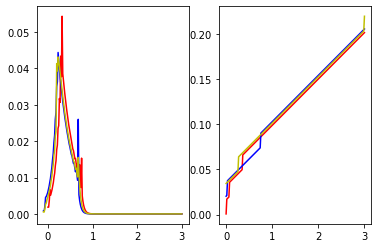

In [713]:
problem_solver(a_lower_1,trans_matrix,l)

It should be lower interest rate and higher asset in theory, but I donot know why it does not show up here.
Economic intuition: With a tighter borrowing constraint,low asset-holding households can not borrow. This means they are less able  to smooth consumption. Therefore, people will save more due to pre-cautionary saving.

# Q3 : different transitional matrix

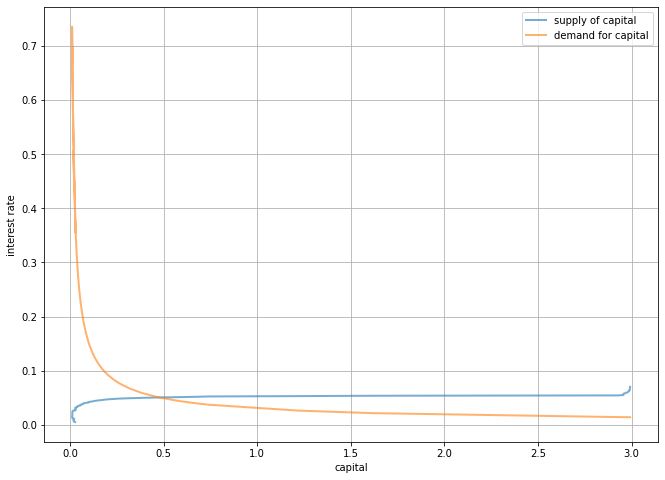

0.0503030303030303
0.05609128267307703


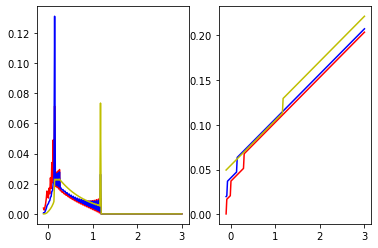

In [716]:
trans_matrix_1 = np.mat('0.6 0.4 0.0; 0.1 0.85 0.05; 0.0 0.1 0.9')
problem_solver(a_lower,trans_matrix_1,l)

Now we have a transitional matrix that makes each labor endowment state more persistent. That is, given today's labor endowment state, there will be a higher possibility of staying at exactly the same state as that of today. This, in another way, implies less risk for people. Therefore, people will save less and the capital supply will decease. As a result, the interest rate increases.

# Q4: mean preserving spread

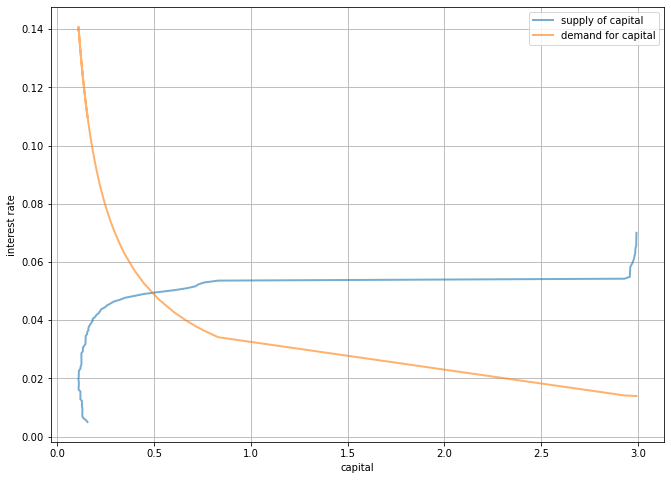

0.048989898989898986
0.05673076374145241


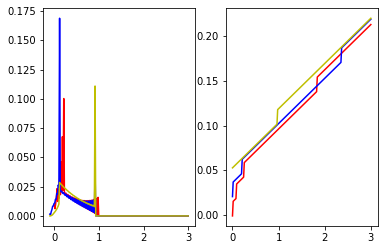

In [718]:
# mu is calculated at the beginning
l_1 = np.array([0.07,1,mu])
problem_solver(a_lower_1,trans_matrix_1,l_1)

Now the people are faced with more risk due to a mean preserving spread in their labor endowment. Thta is, they are faced with more risk. Therefore, people will save more and the interest rate will decrease relative to the case without a mean preserving spread.